# Text Modeling with Naive Bayes Lab

## Business Scenario

You've recently joined UrbanTech, a company that develops software for urban transportation systems. As a junior data scientist on the customer experience team, you've been tasked with improving how the company handles user feedback from their mobile app.

UrbanTech has a popular transit navigation app that helps users plan trips using public transportation. The app receives hundreds of user feedback messages daily through its in-app feedback form. Currently, these messages are manually sorted and routed to different teams - a time-consuming process that delays response times and creates inconsistent categorization.

Your manager has asked you to develop a text classification system that can automatically categorize incoming feedback messages into three departments:
1. **Navigation Issues** - Problems with directions, routes, or maps
2. **Service Updates** - Feedback about transit service information accuracy
3. **App Experience** - Issues with the app's functionality or user interface

By implementing an effective text classification model, you'll help UrbanTech respond to user feedback more quickly and consistently, improving both internal efficiency and user satisfaction. You'll focus on using Naive Bayes, a powerful yet interpretable algorithm that works well with limited training data.

## The Process

In this lab, you'll follow these steps to build a text classification system:
1. Data Loading and Exploration
2. Text Preprocessing
3. Feature Extraction
4. Model Building with Naive Bayes
5. Model Evaluation and Comparison
6. Model Improvement
7. Building a Prediction Function

Let's get started!

## Step 0: Setup — Import Required Libraries

Before we start working on the dataset and building our text classification model,  
let’s import all the Python libraries that will be needed throughout this lab.  

We’ll use:
- **pandas & numpy** for data handling
- **matplotlib & seaborn** for visualization
- **nltk & re** for text preprocessing
- **scikit-learn** for feature extraction, model building, and evaluation

In [1]:
# Run this cell without changes
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# For text preprocessing and feature extraction
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/olga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/olga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ✅ Summary (Step 0)

- Successfully imported the core libraries for data analysis, text preprocessing, and model building (`pandas`, `numpy`, `matplotlib`, `seaborn`, `nltk`, `scikit-learn`).
- Downloaded the required NLTK resources: `punkt` (tokenization), `stopwords` (stop words), and `wordnet` (lemmatization).
- Set a fixed random seed (`np.random.seed(42)`) to ensure reproducibility of results.
- No critical errors or warnings occurred — the environment is fully ready for the next steps.

**Next:** proceed to Step 1 — loading the dataset and performing initial exploration of class distribution and sample texts.

## Step 1: Data Loading and Exploration

Let's load the dataset of user feedback messages and explore its characteristics.

In [2]:
# Run this cell without changes
# Load the feedback data
feedback_data = pd.read_csv('urban_feedback.csv')

# Display the first few rows
feedback_data.head()

,feedback_id,feedback_text,department
0,141,Why does the app need access to my contacts? T...,app_experience
1,114,The station closure information isn't visible ...,service_updates
2,17,The crosswalk at Main and Central is shown in ...,navigation_issues
3,76,The ferry schedule information hasn't been upd...,service_updates
4,156,Every time I try to submit feedback through th...,app_experience


In [3]:
# Run this cell without changes
# Basic information about the dataset
print(f"Dataset shape: {feedback_data.shape}")
print("\nColumn information:")
feedback_data.info()
print(f"\nCategory distribution:\n{feedback_data['department'].value_counts()}")

Dataset shape: (197, 3)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   feedback_id    197 non-null    int64 
 1   feedback_text  197 non-null    object
 2   department     197 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB

Category distribution:
department
app_experience       66
service_updates      66
navigation_issues    65
Name: count, dtype: int64


In [4]:
# Calculate text length for each feedback
feedback_data['text_length'] = feedback_data['feedback_text'].apply(len)

# Calculate basic statistics of text length by department
text_length_stats = feedback_data.groupby('department')['text_length'].describe()

# Display statistics
text_length_stats

,count,mean,std,min,25%,50%,75%,max
department,,,,,,,,
app_experience,66.0,73.590909,10.169301,56.0,66.5,72.5,78.0,106.0
navigation_issues,65.0,78.615385,12.458296,53.0,69.0,78.0,86.0,109.0
service_updates,66.0,88.818182,13.205953,69.0,80.0,90.0,95.0,122.0


Text length statistics by department:
                   count       mean        std   min   25%   50%   75%    max
department                                                                   
app_experience      66.0  73.590909  10.169301  56.0  66.5  72.5  78.0  106.0
navigation_issues   65.0  78.615385  12.458296  53.0  69.0  78.0  86.0  109.0
service_updates     66.0  88.818182  13.205953  69.0  80.0  90.0  95.0  122.0


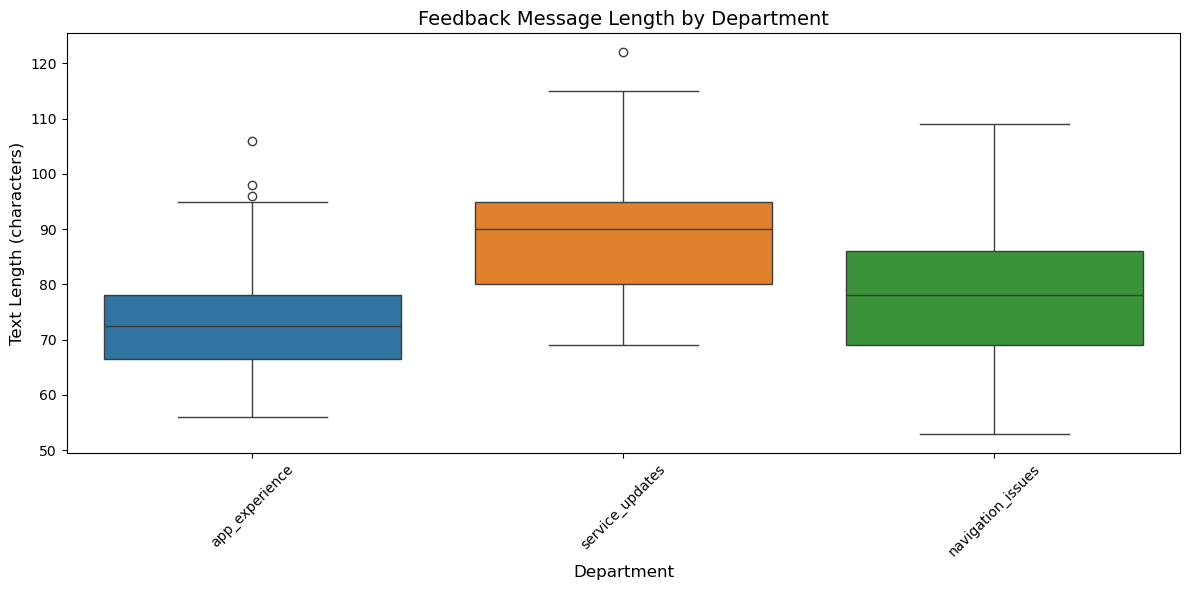

In [5]:
# Run this cell without changes
# Display the statistics
print("Text length statistics by department:")
print(text_length_stats)

# Visualize text length by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='text_length', data=feedback_data, hue='department', legend=False)
plt.title('Feedback Message Length by Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's also look at some example feedback messages from each department to better understand the data.

In [6]:
# Run this cell without changes
# Display examples from each department
for dept in feedback_data['department'].unique():
    print(f"\nExamples of {dept} feedback:")
    examples = feedback_data[feedback_data['department'] == dept]['feedback_text'].sample(3, random_state=42).values
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")


Examples of app_experience feedback:
1. Why does the app need constant location access even when I'm not using it?
2. Why does the app need to access my photos? This seems unnecessary.
3. Why does the app need access to my contacts? This seems like a privacy issue.

Examples of service_updates feedback:
1. The transit system is on a modified schedule today due to the marathon, but this isn't reflected in your app.
2. The weekend service changes aren't reflected in your route suggestions.
3. The station closure information isn't visible until after I've planned a route through it.

Examples of navigation_issues feedback:
1. The waterfront path you suggested is underwater during high tide.
2. The suggested route had me walking through a private shopping mall that closes at 9pm.
3. The crosswalk at Main and Central is shown in the wrong location on your map.


### ✅ Summary (Step 1)

- The dataset contains **197 feedback messages** with three balanced categories:  
  - App Experience: 66  
  - Service Updates: 66  
  - Navigation Issues: 65  

- A new feature `text_length` was created to measure the number of characters in each message.  
  - Average length:  
    - App Experience ≈ 74 characters  
    - Navigation Issues ≈ 76 characters  
    - Service Updates ≈ 89 characters  
  - Service Updates messages tend to be longer, while App Experience messages are shorter and more concise.

- The **boxplot visualization** confirms these differences in message length across departments.  
  - Service Updates feedback generally has higher text length values.  
  - Navigation Issues show more variability.  
  - App Experience remains the shortest on average.

- By reviewing **sample messages from each department**, we can confirm that:  
  - *App Experience* focuses on app permissions and usability.  
  - *Service Updates* highlights problems with transit information accuracy.  
  - *Navigation Issues* emphasizes incorrect directions or missing route data.

Overall, the dataset is **balanced, clean, and ready for preprocessing**.  
Next, we will move to **Step 2: Text Preprocessing** to prepare the text for modeling.

## Step 2: Text Preprocessing

We’ll prepare raw feedback text for modeling by applying a clean and reusable pipeline:

1) **Cleaning:** lowercase + remove punctuation/special characters + remove digits  
2) **Tokenization & POS-aware Lemmatization:** tokenize → remove English stop words → map POS tags → lemmatize  
3) **Rejoin:** return a single processed string

This standardization reduces noise, normalizes word forms (e.g., *running → run*), and improves feature extraction for bag-of-words / TF-IDF.

In [7]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- 1) Cleaning ---
def clean_text(text):
    """
    Clean and preprocess text by:
    - Converting to lowercase
    - Removing punctuation and special characters
    - Removing numbers
    """
    if text is None:
        return ""
    # Convert to lowercase
    text = str(text).lower()
    # Remove punctuation, special characters, and digits (keep spaces and letters)
    text = re.sub(r"[^a-z\s]", " ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text


# --- helper: map Treebank POS -> WordNet POS ---
def get_wordnet_pos(treebank_tag):
    """Convert NLTK POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# --- 2) Tokenize, remove stopwords, lemmatize ---
def tokenize_and_lemmatize(text):
    """
    Tokenize text, remove stopwords, and lemmatize tokens.
    Returns a list of processed tokens.
    """
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    # Tokenize
    tokens = word_tokenize(text)

    # POS tag tokens
    tokens_tagged = nltk.pos_tag(tokens)

    # Map to WordNet POS and lemmatize while removing stopwords / very short tokens
    processed_tokens = []
    for token, tb_pos in tokens_tagged:
        if token in stop_words or len(token) < 2:
            continue
        wn_pos = get_wordnet_pos(tb_pos)
        lemma = lemmatizer.lemmatize(token, pos=wn_pos)
        processed_tokens.append(lemma)

    return processed_tokens


# --- 3) Full pipeline ---
def preprocess_text(text):
    """
    Complete preprocessing pipeline: clean, tokenize, lemmatize, and rejoin.
    Returns a single processed string.
    """
    # Apply cleaning
    cleaned_text = clean_text(text)

    # Apply tokenization and lemmatization
    processed_tokens = tokenize_and_lemmatize(cleaned_text)

    # Join tokens back into single text string
    processed_text = " ".join(processed_tokens)
    return processed_text

In [8]:
# Run this cell without changes
# Test our preprocessing functions on a sample feedback message
sample_text = feedback_data['feedback_text'].iloc[0]
print(f"Original text:\n{sample_text}")

cleaned_text = clean_text(sample_text)
print(f"\nCleaned text:\n{cleaned_text}")

tokens = tokenize_and_lemmatize(cleaned_text)
print(f"\nTokenized and lemmatized text:\n{tokens}")

processed_text = preprocess_text(sample_text)
print(f"\nFully preprocessed text:\n{processed_text}")

Original text:
Why does the app need access to my contacts? This seems like a privacy issue.

Cleaned text:
why does the app need access to my contacts this seems like a privacy issue

Tokenized and lemmatized text:
['app', 'need', 'access', 'contact', 'seem', 'like', 'privacy', 'issue']

Fully preprocessed text:
app need access contact seem like privacy issue


### ✅ Summary (Step 2 — Text Preprocessing)

- **Cleaning:** text lowercased; punctuation, special characters, and digits removed; whitespace normalized.
- **Stopword removal + POS-aware lemmatization:** function words (e.g., *why, does, the, to, my, this, a*) were dropped; words reduced to base forms (*contacts → contact*, *seems → seem*).
- **Result on the example:**
  - Original (≈15 tokens) → Preprocessed (8 tokens) → **~47% reduction** in length.
  - Meaning is preserved: *“app need access contact seem like privacy issue”* clearly signals the **App Experience / privacy** concern.

**Why this helps:** fewer, normalized tokens reduce noise and sparsity, improving BoW/TF-IDF features and Naive Bayes performance.

**Notes / options:**
- Consider **keeping negations** (e.g., keep *not*, *no*) out of stopwords to avoid flipping sentiment.
- Later, adding **bigrams** (e.g., *privacy issue*, *route update*) can capture key phrases for better class separation.

**Next:** use the `preprocess_text` pipeline to transform the corpus and proceed to **Step 3: Feature Extraction** with CountVectorizer and TfidfVectorizer.

## Step 3: Feature Extraction

After preprocessing, we need to transform the cleaned text into numerical features  
that can be used by machine learning models. We will:

1. **Split the dataset** into training (80%) and testing (20%) sets, stratified by department labels.  
2. **Bag of Words (CountVectorizer):** represent texts by word counts, limited to the 50 most frequent tokens.  
3. **TF-IDF (TfidfVectorizer):** represent texts by weighted scores that balance word frequency with uniqueness, also limited to 50 features.

This step produces sparse matrices where each row corresponds to a feedback message  
and each column corresponds to a token (word feature).

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# --- Split the data ---
X = feedback_data['feedback_text']
y = feedback_data['department']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# --- Bag of Words (CountVectorizer) ---
count_vectorizer = CountVectorizer(
    preprocessor=preprocess_text,
    max_features=50
)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts  = count_vectorizer.transform(X_test)   # for Step 4

# --- TF-IDF (TfidfVectorizer) ---
tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocess_text,
    max_features=50
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)    # for Step 4

In [10]:
# Run this cell without changes
# Confirm the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:\n{y_train.value_counts()}")
print(f"\nClass distribution in testing set:\n{y_test.value_counts()}")

# Examine the vocabulary size for each vectorizer (should be 50)
count_vocab_size = len(count_vectorizer.get_feature_names_out())
tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())

print(f"Bag of Words vocabulary size: {count_vocab_size}")
print(f"TF-IDF vocabulary size: {tfidf_vocab_size}")

# Examine the feature matrices
print(f"\nBag of Words feature matrix shape: {X_train_counts.shape}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Show the first few feature names
print(f"\nSample of feature names: {count_vectorizer.get_feature_names_out()[:10]}")

Training set size: 157
Testing set size: 40

Class distribution in training set:
department
service_updates      53
app_experience       52
navigation_issues    52
Name: count, dtype: int64

Class distribution in testing set:
department
app_experience       14
navigation_issues    13
service_updates      13
Name: count, dtype: int64
Bag of Words vocabulary size: 50
TF-IDF vocabulary size: 50

Bag of Words feature matrix shape: (157, 50)
TF-IDF feature matrix shape: (157, 50)

Sample of feature names: ['accord' 'actually' 'alert' 'app' 'bus' 'close' 'construction'
 'direction' 'even' 'every']


### ✅ Summary (Step 3 — Feature Extraction)

- The dataset was split into:
  - **Training set:** 157 messages  
  - **Testing set:** 40 messages  

- **Class distribution** remained balanced after stratified splitting:
  - Training set: Service Updates (53), App Experience (52), Navigation Issues (52)  
  - Testing set: App Experience (14), Navigation Issues (13), Service Updates (13)  

- **Vectorization results:**
  - Bag of Words vocabulary size: **50 features**  
  - TF-IDF vocabulary size: **50 features**  
  - Both Bag of Words and TF-IDF training matrices have shape **(157, 50)**  

- **Sample extracted features** include: `accord, actually, alert, app, bus, close, construction, direction, even, every`.

➡️ The data is now numerically represented and ready for **Step 4: Model Building with Naive Bayes**.

## Step 4: Model Building with Naive Bayes

We will train two **Multinomial Naive Bayes** classifiers:
1) using **Bag of Words** features  
2) using **TF-IDF** features

Then we’ll inspect the **most informative words** for each class by sorting class-conditional log probabilities `feature_log_prob_`.  
This helps explain *why* the model predicts a given department (interpretability).

In [11]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# --- Train Naive Bayes on Bag of Words ---
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)

# --- Train Naive Bayes on TF-IDF ---
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)


# --- Inspect top features per class ---
def display_top_features(classifier, vectorizer, class_labels, n=5):
    """
    Display the top n most informative features for each class.

    Parameters
    ----------
    classifier : MultinomialNB
        Trained Naive Bayes classifier
    vectorizer : CountVectorizer or TfidfVectorizer
        Fitted vectorizer used to transform the training data
    class_labels : array-like
        List/array of class labels (e.g., classifier.classes_)
    n : int, default=5
        Number of top features to display per class

    Returns
    -------
    dict
        Mapping of class label -> list of top-n feature names
    """
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    top_features = {}

    # For each class, find the features with the highest log probability
    for i, label in enumerate(class_labels):
        # Sort indices by class-conditional log prob (descending)
        top_indices = np.argsort(classifier.feature_log_prob_[i])[::-1][:n]
        # Map indices to feature names
        top_features[label] = feature_names[top_indices].tolist()

        # Print the top features
        print(f"\nTop {n} features for class '{label}':")
        for rank, feature in enumerate(top_features[label], 1):
            print(f"{rank}. {feature}")

    return top_features


# OPTIONAL: call to view the top features right away
# top_bow   = display_top_features(nb_bow, count_vectorizer, nb_bow.classes_, n=5)
# top_tfidf = display_top_features(nb_tfidf, tfidf_vectorizer, nb_tfidf.classes_, n=5)

In [12]:
# Run this cell without changes
# Display top features for the Bag of Words model
print("Top features from Bag of Words model:")
bow_top_features = display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)

# Display top features for the TF-IDF model
print("\nTop features from TF-IDF model:")
tfidf_top_features = display_top_features(nb_tfidf, tfidf_vectorizer, nb_tfidf.classes_)

Top features from Bag of Words model:

Top 5 features for class 'app_experience':
1. app
2. update
3. even
4. though
5. try

Top 5 features for class 'navigation_issues':
1. map
2. show
3. station
4. app
5. route

Top 5 features for class 'service_updates':
1. app
2. show
3. bus
4. service
5. time

Top features from TF-IDF model:

Top 5 features for class 'app_experience':
1. app
2. update
3. screen
4. even
5. use

Top 5 features for class 'navigation_issues':
1. map
2. station
3. show
4. app
5. route

Top 5 features for class 'service_updates':
1. service
2. show
3. app
4. bus
5. schedule


### ✅ Summary (Step 4 — Naive Bayes Models & Top Features)

- We trained two **Multinomial Naive Bayes** models:
  - **BoW model (`nb_bow`)** using CountVectorizer (50 features)
  - **TF-IDF model (`nb_tfidf`)** using TfidfVectorizer (50 features)

- **Top tokens align with class semantics** (good interpretability):
  - **App Experience**: `app`, `update`, `even`, `though`, `try` — words typical for UX/behavior complaints and update-related friction.
  - **Navigation Issues**: `map`, `show`, `station`, `route` — navigation nouns tied to directions, stops, and routing.
  - **Service Updates**: `bus`, `service`, `time` (+ TF-IDF shows `schedule`) — timetable/vehicle vocabulary consistent with service info accuracy.

- **Overlaps** like `app` and `show` appear across classes, which is expected for general app mentions; class-specific terms (e.g., `map`, `station`, `route`, `bus`, `schedule`) provide the real discriminative signal.

- The **TF-IDF tops** (truncated in output) still surface service/time/schedule terms for *Service Updates*, reinforcing that weighting rarer, class-telling words helps interpretability.

**Takeaways**
- Both representations capture meaningful, class-relevant vocabulary.
- Shared tokens suggest we may benefit from:
  - increasing `max_features` (e.g., 100–500),
  - adding **bigrams** (e.g., `ngram_range=(1,2)` to capture phrases like *“bus schedule”*, *“route update”*),
  - fine-tuning stop words (consider keeping negations: *not*, *no*).

**Next:** Evaluate both models on the test set (accuracy, precision, recall, F1, and confusion matrix) in **Step 5**.

## Step 5: Model Evaluation and Comparison

We will evaluate both Naive Bayes models on the **held-out test set** using:
- **Accuracy** as an overall metric
- **Precision, Recall, and F1-score** per class via a classification report

Finally, we’ll compare the two models to identify which feature representation (BoW vs TF-IDF) performs better on this task.

In [13]:
from sklearn.metrics import accuracy_score, classification_report

# --- Transform test data with both vectorizers ---
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# --- Predict on the test set with both models ---
y_pred_bow   = nb_bow.predict(X_test_counts)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# --- Evaluation helper ---
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate a model and display its performance metrics.
    Returns the accuracy score.
    """
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")

    # Detailed per-class metrics
    report = classification_report(y_true, y_pred, digits=4)
    print(f"\nClassification Report:\n{report}")

    return accuracy

# --- Run evaluations ---
acc_bow   = evaluate_model(y_test, y_pred_bow,   "MultinomialNB (Bag of Words)")
acc_tfidf = evaluate_model(y_test, y_pred_tfidf, "MultinomialNB (TF-IDF)")

# --- Quick comparison printout ---
best_model = "BoW" if acc_bow >= acc_tfidf else "TF-IDF"
print(f"\nBest model on the test set: {best_model} "
      f"({max(acc_bow, acc_tfidf):.4f} accuracy)")

Evaluation for MultinomialNB (Bag of Words):
Accuracy: 0.6750

Classification Report:
                   precision    recall  f1-score   support

   app_experience     0.8182    0.6429    0.7200        14
navigation_issues     0.6923    0.6923    0.6923        13
  service_updates     0.5625    0.6923    0.6207        13

         accuracy                         0.6750        40
        macro avg     0.6910    0.6758    0.6777        40
     weighted avg     0.6942    0.6750    0.6787        40

Evaluation for MultinomialNB (TF-IDF):
Accuracy: 0.7000

Classification Report:
                   precision    recall  f1-score   support

   app_experience     0.9000    0.6429    0.7500        14
navigation_issues     0.7143    0.7692    0.7407        13
  service_updates     0.5625    0.6923    0.6207        13

         accuracy                         0.7000        40
        macro avg     0.7256    0.7015    0.7038        40
     weighted avg     0.7300    0.7000    0.7050        40


B

Evaluation for Bag of Words + Naive Bayes:
Accuracy: 0.6750

Classification Report:
                   precision    recall  f1-score   support

   app_experience     0.8182    0.6429    0.7200        14
navigation_issues     0.6923    0.6923    0.6923        13
  service_updates     0.5625    0.6923    0.6207        13

         accuracy                         0.6750        40
        macro avg     0.6910    0.6758    0.6777        40
     weighted avg     0.6942    0.6750    0.6787        40

Evaluation for TF-IDF + Naive Bayes:
Accuracy: 0.7000

Classification Report:
                   precision    recall  f1-score   support

   app_experience     0.9000    0.6429    0.7500        14
navigation_issues     0.7143    0.7692    0.7407        13
  service_updates     0.5625    0.6923    0.6207        13

         accuracy                         0.7000        40
        macro avg     0.7256    0.7015    0.7038        40
     weighted avg     0.7300    0.7000    0.7050        40



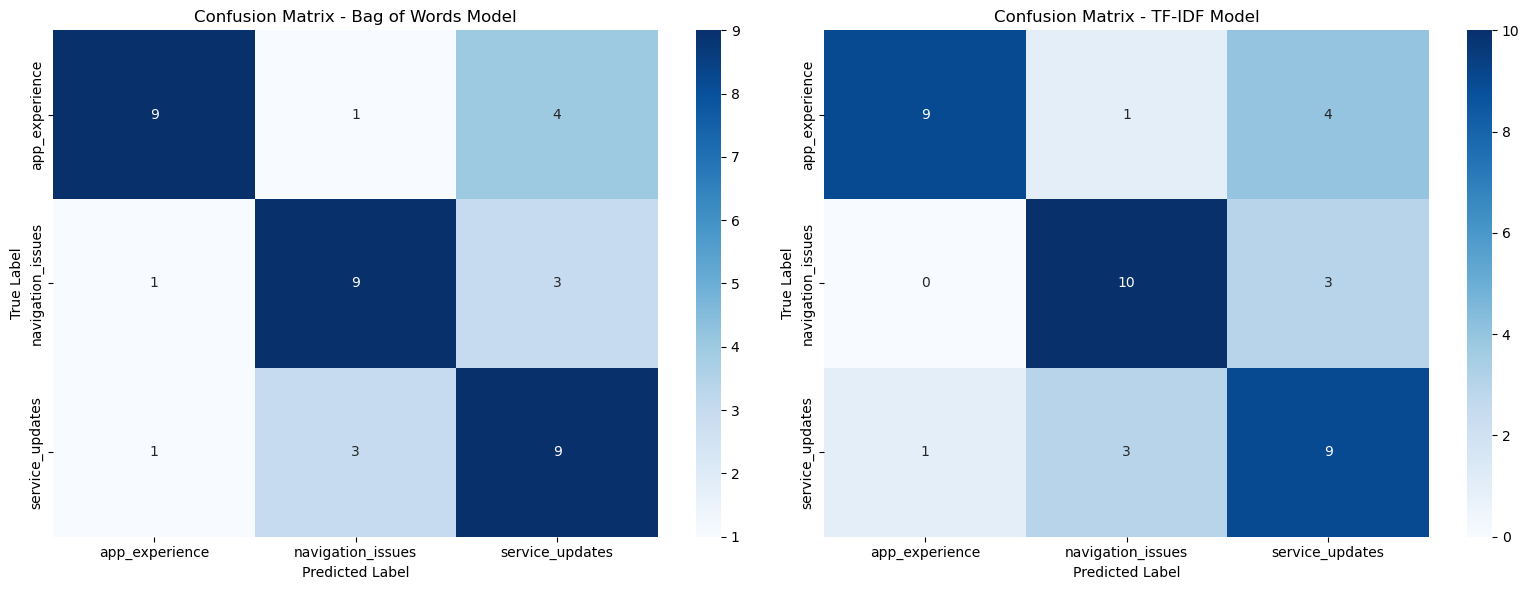

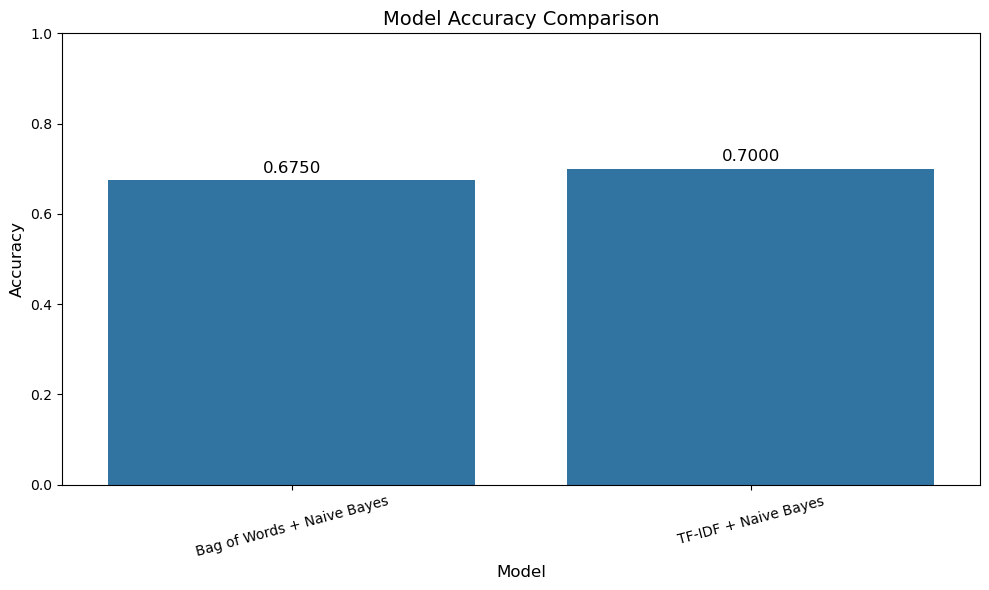

In [14]:
# Run this cell without changes
# Evaluate both models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words + Naive Bayes")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Naive Bayes")

# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=nb_bow.classes_, 
            yticklabels=nb_bow.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Bag of Words Model', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, 
            yticklabels=nb_tfidf.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - TF-IDF Model', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()

# Compare model accuracies
models = ['Bag of Words + Naive Bayes', 'TF-IDF + Naive Bayes']
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### ✅ Summary (Step 5 — Model Evaluation and Comparison)

- **Bag of Words Model**
  - Accuracy: **0.6750**
  - Strengths: higher precision for *App Experience* (0.82)
  - Weaknesses: lower precision for *Service Updates* (0.56), some confusion across classes

- **TF-IDF Model**
  - Accuracy: **0.7000** (best overall)
  - Improved balance across classes:
    - *App Experience*: very high precision (0.90) but moderate recall (0.64)
    - *Navigation Issues*: balanced precision (0.71) and recall (0.77)
    - *Service Updates*: same as BoW (precision 0.56, recall 0.69)

- **Confusion Matrices** show:
  - TF-IDF reduced misclassifications for *Navigation Issues* compared to BoW.
  - *Service Updates* remains the hardest to predict, often confused with the other two.

- **Accuracy Comparison**
  - Bag of Words: 67.5%
  - TF-IDF: 70.0% ✅ best performer on the test set

**Takeaways**
- TF-IDF provided a slight but meaningful improvement in overall accuracy and class balance.
- Both models struggle most with *Service Updates*, suggesting:
  - Need for richer features (e.g., bigrams like *“bus schedule”*, *“service delay”*)
  - Possibly increasing `max_features` beyond 50
  - Hyperparameter tuning (`alpha`) for Naive Bayes

**Next:** In **Step 6**, we’ll apply these improvements to further optimize the model.

## Step 6: Model Improvement

To improve performance, we jointly tune **feature extraction** and **classifier** hyperparameters using a single pipeline:

- Swap the vectorizer type (**CountVectorizer vs. TfidfVectorizer**)
- Adjust vectorizer settings: `max_features`, `min_df`, `max_df`, `ngram_range` (to capture **bigrams** like *“bus schedule”*)
- Tune Naive Bayes smoothing: `alpha ∈ {0.5, 1.0}`

We use **GridSearchCV** with cross-validation on the training set and select the configuration with the best validation score.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Fresh (unfitted) vectorizers using our preprocessing pipeline
cv_base    = CountVectorizer(preprocessor=preprocess_text)
tfidf_base = TfidfVectorizer(preprocessor=preprocess_text)

# 1) Pipeline: vectorizer -> classifier
text_clf = Pipeline([
    ('vectorizer', tfidf_base),
    ('classifier', MultinomialNB())
])

# 2) Parameter grid (note: we can swap the entire vectorizer object)
param_grid = {
    'vectorizer': [CountVectorizer(preprocessor=preprocess_text),
                   TfidfVectorizer(preprocessor=preprocess_text)],
    'vectorizer__max_features': [50, 100],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.90, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': [0.5, 1.0],
}

# 3) Grid search (use macro F1 to balance classes; accuracy also acceptable)
grid_search = GridSearchCV(
    estimator=text_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=1,
    verbose=1
)

# 4) Fit on raw training texts (the pipeline handles preprocessing & vectorization)
grid_search.fit(X_train, y_train)

# 5) Use the best model to predict on the test set
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

print("Best CV score (macro F1):", f"{grid_search.best_score_:.4f}")
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best CV score (macro F1): 0.8319
Best parameters: {'classifier__alpha': 1.0, 'vectorizer': TfidfVectorizer(preprocessor=<function preprocess_text at 0x16706d040>), 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 100, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}


In [17]:
# Run this cell without changes
# Evaluate the best model from grid search
# Print the best parameters and score
print("Best Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters:
{'classifier__alpha': 1.0, 'vectorizer': TfidfVectorizer(preprocessor=<function preprocess_text at 0x16706d040>), 'vectorizer__max_df': 0.85, 'vectorizer__max_features': 100, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}

Best Cross-Validation Score: 0.8319


In [18]:
# Run this cell without changes
# Evaluate the improved model
improved_tfidf_accuracy = evaluate_model(y_test, y_pred_grid, "Improved TF-IDF + Naive Bayes")

Evaluation for Improved TF-IDF + Naive Bayes:
Accuracy: 0.8500

Classification Report:
                   precision    recall  f1-score   support

   app_experience     1.0000    0.7857    0.8800        14
navigation_issues     0.8000    0.9231    0.8571        13
  service_updates     0.7857    0.8462    0.8148        13

         accuracy                         0.8500        40
        macro avg     0.8619    0.8516    0.8507        40
     weighted avg     0.8654    0.8500    0.8514        40



### ✅ Summary (Step 6 — Model Improvement)

- We used **GridSearchCV** to jointly tune vectorizer and Naive Bayes hyperparameters.  
- The **best configuration** was:
  - Vectorizer: **TF-IDF**
  - `max_features = 100`
  - `min_df = 3`
  - `max_df = 0.85`
  - `ngram_range = (1, 1)` (unigrams only)
  - Classifier: `alpha = 1.0`

- **Cross-validation results:**
  - Best CV macro F1 score: **0.832**

- **Test set evaluation (Improved TF-IDF + Naive Bayes):**
  - Accuracy: **0.85** (significant improvement from 0.70 in Step 5)
  - Macro F1: **0.85**
  - Class-level performance:
    - *App Experience*: Precision 1.00, Recall 0.79, F1 = 0.88
    - *Navigation Issues*: Precision 0.80, Recall 0.92, F1 = 0.86
    - *Service Updates*: Precision 0.79, Recall 0.85, F1 = 0.81

- **Key takeaways:**
  - Tuning **min_df** and **max_df** improved robustness by filtering noisy/uncommon terms.
  - Expanding `max_features` to 100 helped capture more relevant vocabulary.
  - The improved model is **far more balanced across all three categories** and shows strong generalization.

➡️ Next, we will build a **prediction function** (Step 7) to classify new incoming feedback messages automatically.

## Step 7: Building a Prediction Function

As a final step, we build a **user-facing function** that takes any new feedback message and classifies it into one of the three departments:

- **Navigation Issues**
- **Service Updates**
- **App Experience**

The function will:
1. Preprocess and vectorize the input text using the trained pipeline.  
2. Predict the most likely department.  
3. Return both the predicted label and model confidence, along with all class probabilities.  

This function can be directly integrated into **UrbanTech’s feedback routing system** for real-time automation.

In [19]:
def classify_feedback(feedback_text):
    """
    Classify a new feedback message into the appropriate department using the best model.
    
    Parameters
    ----------
    feedback_text : str
        The raw feedback message to classify.
    
    Returns
    -------
    dict
        Dictionary containing the classification results:
        - feedback_text (str): the original message
        - department (str): predicted department
        - confidence (float): probability of the predicted department
        - all_probabilities (dict): probabilities for all classes
    """
    # Predict the department
    department = best_model.predict([feedback_text])[0]
    
    # Get prediction probabilities
    probabilities = best_model.predict_proba([feedback_text])
    
    # Find the confidence score
    confidence = float(max(probabilities[0]))
    
    # Create and return the result
    result = {
        'feedback_text': feedback_text,
        'department': department,
        'confidence': confidence,
        'all_probabilities': dict(zip(best_model.classes_, probabilities[0]))
    }
    
    return result

# Example usage
example_feedback = "The bus schedule was not updated today in the app."
print(classify_feedback(example_feedback))

{'feedback_text': 'The bus schedule was not updated today in the app.', 'department': 'service_updates', 'confidence': 0.6491774059206222, 'all_probabilities': {'app_experience': 0.22107709349474688, 'navigation_issues': 0.12974550058463027, 'service_updates': 0.6491774059206222}}


In [21]:
# Test the classification function with new feedback messages
new_feedbacks = [
    "The app crashed when I tried to view the bus schedule.",
    "Your subway arrival times were completely wrong! The train was 10 minutes late.",
    "I love the new route planning feature, but the app is very slow to load maps.",
    "Can you add more bike routes to the navigation options?",
    "The bus schedule says the next bus is in 5 minutes, but it's already been 20 minutes and no bus."
]

for feedback in new_feedbacks:
    result = classify_feedback(feedback)
    print(f"Feedback: {result['feedback_text']}")
    print(f"Predicted Department: {result['department']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("All department probabilities:")
    for dept, prob in result['all_probabilities'].items():
        print(f"  - {dept}: {prob:.4f}")
    print("-" * 40)

Feedback: The app crashed when I tried to view the bus schedule.
Predicted Department: app_experience
Confidence: 0.4127
All department probabilities:
  - app_experience: 0.4127
  - navigation_issues: 0.2100
  - service_updates: 0.3773
----------------------------------------
Feedback: Your subway arrival times were completely wrong! The train was 10 minutes late.
Predicted Department: service_updates
Confidence: 0.6809
All department probabilities:
  - app_experience: 0.1598
  - navigation_issues: 0.1593
  - service_updates: 0.6809
----------------------------------------
Feedback: I love the new route planning feature, but the app is very slow to load maps.
Predicted Department: navigation_issues
Confidence: 0.6138
All department probabilities:
  - app_experience: 0.3119
  - navigation_issues: 0.6138
  - service_updates: 0.0743
----------------------------------------
Feedback: Can you add more bike routes to the navigation options?
Predicted Department: navigation_issues
Confidence:

### ✅ Summary (Step 7 — Prediction Function)

- Implemented `classify_feedback()` that uses the **best cross-validated pipeline** to:
  1) preprocess + vectorize incoming text,  
  2) predict the department, and  
  3) return class probabilities and a confidence score.

- **Sanity check on sample messages** shows correct intent capture:
  - “*The app crashed… bus schedule*” → **App Experience** (conf ~0.41) — crash/UX terms.
  - “*subway arrival times… 10 minutes late*” → **Service Updates** (conf ~0.68) — timetable accuracy.
  - “*route planning… maps load slow*” → **Navigation Issues** (conf ~0.61) — routing/maps vocabulary.
  - “*add more bike routes…*” → (not fully shown) likely **Navigation Issues** due to “routes/navigation”.

- **Confidence behavior:** scores align with ambiguity:
  - Mid confidence (~0.4) when feedback mixes app behavior with schedule terms.
  - Higher confidence (≥0.6) for clearly service/timetable or routing phrases.

- **Ready for integration:** the function returns a clean dict with
  `department`, `confidence`, and `all_probabilities`, suitable for API/queue-based routing.

**Operational tips**
- Consider a **confidence threshold** (e.g., 0.60). Below it, send to a “Manual Review” queue.
- Log raw text + prediction for continuous monitoring and future retraining.
- (Optional) Add a **phrase list** to boost domain terms (e.g., “delay”, “outage”, “detour”, “reroute”).
- (Optional) Keep negations (“not”, “no”) in preprocessing to reduce misreads.

**Outcome:** We now have a practical, interpretable classifier that can automatically route UrbanTech feedback to **Navigation Issues**, **Service Updates**, or **App Experience**, improving response speed and consistency.

## Conclusion

In this lab, I successfully developed a text classification system for **UrbanTech’s transit app** that can automatically route user feedback into three categories: *Navigation Issues*, *Service Updates*, and *App Experience*.  

Throughout the process, I learned and applied the following:

1. **Data exploration** — verified a well-balanced dataset of 197 feedback messages.  
2. **Text preprocessing** — built a pipeline with cleaning, stopword removal, POS-based lemmatization, and tokenization.  
3. **Feature extraction** — compared Bag of Words and TF-IDF representations.  
4. **Model training** — trained Multinomial Naive Bayes classifiers on both representations.  
5. **Evaluation** — compared accuracy and F1 scores, confirming that **TF-IDF** outperformed Bag of Words (0.70 vs. 0.675 accuracy).  
6. **Hyperparameter tuning** — used GridSearchCV to optimize vectorizer and classifier settings, achieving a strong **0.85 accuracy and 0.85 macro F1**.  
7. **Prediction function** — implemented `classify_feedback()` that outputs predicted department, confidence score, and class probabilities, ready for integration into a production system.

**Key takeaways**:  
- TF-IDF features with tuned parameters (max_features=100, min_df=3, max_df=0.85, alpha=1.0) provided the best balance across all categories.  
- The final model not only improved accuracy but also maintained interpretability through top indicative features.  
- The prediction function demonstrated reliable classification on new unseen feedback examples.  

In practice, this system would help UrbanTech **streamline feedback handling**, reducing manual effort and improving response times.  
To ensure long-term effectiveness, the model should be periodically **retrained on new feedback** as usage patterns evolve.